In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import re 
import sys
from distutils.dir_util import copy_tree

import subprocess
import json

import subprocess
import time
from pathlib import Path

cd = os.getcwd()
cwd = Path(cd,'..')

# cwd = r'/Users/eusefalee/Library/CloudStorage/OneDrive-Personal/Desktop/PhD/Fall2022/woodSDA_shared'

sys.path.append(os.path.join(cwd, *['Codes','DesignTool']))
sys.path.append(os.path.join(cwd, *['Codes','ModelingTool']))
sys.path.append(os.path.join(cwd, *['Codes', 'PostProcessing']))

####################### Modules required for Design Tool ##################
from FinalShearWallDesign_allFloors import FinalShearWallDesign
from StiffnessBasedDesign import RDADesignIterationClass

####################### Modules required for OpenSees Modeling ##################
# os.chdir(os.path.join(cwd, *['Codes','ModelingTool']))
from BuildingModelClass import BuildingModel
from utils import *

####################### Modules required for Post-Processing ##################
import ExtractMaxEDP as extractedps
import ExtractPushoverData as epd
import csv
import math

####################### Modules required for Loss Assessment ##################
# and import pelicun classes and methods
# from pelicun.base import set_options, convert_to_MultiIndex
# from pelicun.assessment import Assessment

# pd.set_option('display.max_colwidth', 100)
%load_ext autoreload
%autoreload 2

In [ ]:
# !pip install pelicun==3.1.b6

### setting up directories and folders to store the building models

In [2]:
# Utility function directory 
UtilDirectory = os.path.join(cwd, *['Codes','ModelingTool'])
# Base directory is the main directory that models, model inputs and utility directory stores
BaseDirectory = cwd
# Model directory is where you want to store your model
ModelDirectory = os.path.join(cwd, 'BuildingModels')
# DB directory is where you store Database.csv (for steel section)
DBDirecctory = UtilDirectory

# If there is no model directory, create one
if os.path.isdir(ModelDirectory) != True:
    os.chdir(BaseDirectory)
    os.mkdir('BuildingModels')

## create a directory to story results
resultDirectory = os.path.join(cwd, 'Results')
if os.path.isdir(resultDirectory) != True:
    os.chdir(cwd)
    os.mkdir('Results')
    
# Read in building name(s) 
# Make sure the building name is consistent with the input folders
os.chdir(os.path.join(cwd, 'Codes'))
with open('BuildingNames_woodSDATest.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s4_96x48']

## Implement design module

No need to post-process the outputs of design module. The modeling module is able to read in the required inputs from design module's output

In [3]:
start = time.time()
# caseID = 'woodSDATestModel'
caseID = BuildingList[0]
basedirectory = os.path.join(cwd, *['BuildingInfo', caseID])
numFloors = 4
# direction = ['X', 'X', 'Y', 'Y', 'Y']
# wall_line_name = ['sw1', 'sw2', 'swA', 'swB', 'swC']
# numWallsPerLine = [2,2,2,2,2]
 
direction = ['X', 'X', 'X', 
             'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
wall_line_name = ['gridA', 'gridB', 'gridC',
                  'grid1', 'grid2','grid3','grid4','grid5','grid6', 'grid7']
numWallsPerLine = [4, 4, 4,
                  2, 2, 4, 2, 4, 2, 2]
counter = 0

rda = RDADesignIterationClass(caseID, basedirectory, direction,numWallsPerLine, counter, wall_line_name,
                              weight_factor=1, seismic_design_level='Extreme', mat_ext_int='HWS_GWB')

# rda.maindf
# rda.maindf.to_csv(os.path.join(resultDirectory, "FinalDesignOutput.csv"))
stop = time.time()
print( stop - start, 'seconds')

Check:  
   Sheathing Type Material  nail size panel thickness  nail spacing  Vs (plf)  \
0             GWB   Gypsum  5d cooler           1/2in             7       200   
1             WSP      OSB         6d           3/8in             6       400   
2             WSP      OSB         8d          7/16in             6       480   
3             WSP      OSB        10d         19/32in             6       680   
4             WSP      OSB         8d          7/16in             4       700   
5             WSP      OSB         8d         15/32in             4       760   
6             WSP      OSB         8d          7/16in             3       900   
7             WSP      OSB        10d         15/32in             4       920   
8             WSP      OSB         6d           3/8in             2      1020   
9             WSP      OSB         8d          7/16in             2      1170   
10   Structural I      OSB         8d           3/8in             2      1220   
11            WSP  

In [4]:
rda.maindf

Shear Wall Assembly  \
swDesign_gridA_wall1 0  Use 1/2in GWB with 5d cooler nails @ 7in o.c. ...   
                     1  Use 19/32in WSP on 1 side with 10d nails @ 6o....   
                     2  Use 3/8in WSP on 1 side with 6d nails @ 2o.c. ...   
                     3  Use 15/32in WSP on 1 side with 10d nails @ 2o....   
swDesign_gridA_wall2 0  Use 1/2in GWB with 5d cooler nails @ 7in o.c. ...   
...                                                                   ...   
swDesign_grid7_wall1 3  Use 15/32in WSP on 1 side with 10d nails @ 2o....   
swDesign_grid7_wall2 0  Use 1/2in GWB with 5d cooler nails @ 7in o.c. ...   
                     1  Use 7/16in WSP on 1 side with 8d nails @ 6o.c....   
                     2  Use 7/16in WSP on 1 side with 8d nails @ 3o.c....   
                     3  Use 15/32in WSP on 1 side with 10d nails @ 2o....   

                        Ga(k/in)  level  LRFD(klf)  Drift(in)  D/C Ratio  \
swDesign_gridA_wall1 0       5.2      4      0.160   1.183003   0.809222   
                     1      19.0      3      0.544   0.812688   0.714019   
                     2      32.0      2      0.816   0.901774   0.952026   
                     3      52.0      1      1.232   0.921743   0.894849   
swDesign_gridA_wall2 0       5.2      4      0.160   1.141859   0.809368   
...                          ...    ...        ...        ...        ...   
swDesign_grid7_wall1 3      52.0      1      1.232   1.270957   0.805445   
swDesign_grid7_wall2 0       5.2      4      0.160   1.178956   0.728373   
                     1      15.0      3      0.384   1.031290   0.910466   
                     2      28.0      2      0.720   1.143055   0.971163   
                     3      52.0      1      1.232   1.270957   0.805445   

                        OpenSees Tag  
swDesign_gridA_wall1 0            14  
                     1             8  
                     2             6  
                     3            11  
swDesign_gridA_wall2 0            14  
...                              ...  
swDesign_grid7_wall1 3            11  
swDesign_grid7_wall2 0            14  
                     1             1  
                     2             2  
                     3            11  

[120 rows x 7 columns]

In [5]:
import psutil;
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2, 'MB memory required')


163.3125 MB memory required


## Implement modeling module

The following code creates three sets of 3D OpenSees Models- Eigenvalue, pushover, and dyanmic analysis. The flag ___RunPushoverSwitch___ automatically runs the pushover analysis after creating the required tcl files.

In [6]:
start = time.time()

# Generate eigen analysis, pushover analysis and dynamic analysis models for each one in the building list
for i in range(0, len(BuildingList)):
    design_level = 'Extreme'
        
    InfoDirectory = os.path.join(BaseDirectory, *['BuildingInfo', '%s'%BuildingList[i]])
    ModelClass = BuildingModel(BuildingList[i], InfoDirectory, seismic_design_level = design_level)

    # alternatively, one can choose to read inputs from json 
    ModelClass.read_in_txt_inputs(BuildingList[i], InfoDirectory)

    if os.path.isdir(ModelDirectory+'/%s'%BuildingList[i]) != True:
        os.chdir(ModelDirectory)
        os.mkdir('%s'%BuildingList[i])
        
    os.chdir(ModelDirectory+'/%s'%BuildingList[i])
    period = generateModalAnalysisModel(ModelClass.ID, ModelClass, BaseDirectory, DBDirecctory)
    # Turn off RunPushoverSwitch to speed up the model creation 
    generatePushoverAnalysisModel(ModelClass.ID, ModelClass, BaseDirectory, DBDirecctory,
                               GenerateModelSwitch = True, RunPushoverSwitch = True)
    generateDynamicAnalysisModel(ModelClass.ID, ModelClass, BaseDirectory, DBDirecctory, period,
                               GenerateModelSwitch = True)
    print(period)
    print(BuildingList[i])

finish = time.time()
print((finish - start)/60, 'Minutes')



         OpenSees -- Open System For Earthquake Engineering Simulation
                 Pacific Earthquake Engineering Research Center
                        Version 3.3.0 64-Bit

      (c) Copyright 1999-2016 The Regents of the University of California
                              All Rights Reserved
  (Copyright and Disclaimer @ http://www.berkeley.edu/OpenSees/copyright.html)


Variables Defined
Units and Constants Defined
FUNCTIONS and PROCEDURES: Sourced
x-direction wood panel nodes defined
z-direction wood panel nodes defined
main leaning column nodes defined
Leaning column nodes for zero length spring defined
rigid diaphragm constraints defined
fixities at x-direction wood panel nodes defined
fixities at z-direction wood panel nodes defined
fixities at leaning column nodes defined
x-direction wood panel nodes defined
z-direction wood panel nodes defined
wood panel materials defined
x-direction wood panels defined
z-direction wood panels defined
Leaning columns defined
Leanin

[0.7578038516504025, 0.5053044722365547, 0.48328501977715094, 0.28117104397290943]
s4_96x48
18.209269030888876 Minutes


Pushover analysis completed SUCCESSFULLY
DonePushover
Run Time = 542 Seconds


### Run dynamic analysis 

Files required to run dynamic analysis has been created in the previous step, the following code iteratively runs the dynamic analysis upto the specified number of Ground motions.


In [7]:
### MSA using selected GM records for 5 hazard levels. Location: Boelter Hall
Scale_Sa_GM = '0.403 0.975 1.307 1.676 2.237'
GM_Num = '50 47 47 48 47'

# GM_ID = 1 # GM pair
GM_folder = r'GM_sets/BoelterHall'

Model_Name = BuildingList[0]


# start_ID is tarting index which starts from 1 instead of 0
# finish_ID is the total number of GMs in multiple stripe or incremental dynamic analysis
# for eg: if you have 10 hazard levels with 22 GM pairs, finish_id should be 10*22 + 1
start_ID, finish_ID = 1, 3 # for demonstration I'm running dynamic analysis for 2 ground motion pairs
acc_time = 0
start_time = time.time()

ModelDirectory = r'/Users/eusefalee/Library/CloudStorage/OneDrive-Personal/Desktop/PhD/Fall2022/woodSDA_shared/BuildingModels'

## following chucks of codes run dynamic analysis for each ground motion pair iteratively
# Pairing ID == 1 i.e. apply H1 motion in X and H2 motion in Z
for GM_ID in range(start_ID, finish_ID):
    s = time.time()
    SetupDyamaicAnalysis(ModelDirectory, Scale_Sa_GM, GM_Num, GM_ID, GM_folder, Model_Name, 1)
    os.chdir(ModelDirectory)
    r = os.system('/Applications/OpenSees/bin/OpenSees RunDynamic_Single.tcl')
    f = time.time()
    if not r: 
        print('Hazard Level %i GM Pair %s with Pairing ID %i has finished successfully in %.3fs!'%(int(GM_ID/50)+1, str(GM_ID-int(GM_ID/50)), 1, f-s))
        os.remove('RunDynamic_Single.tcl')
        acc_time += (f-s)
        #print('Estimate remaining time %.3fs!'%(acc_time/(GM_ID - start_ID)*(finish_ID - GM_ID)))
    else: 
        print('GM Pair %s has failed'%str(GM_ID))
        break

# Pairing ID == 2 i.e. apply H2 motion in X and H1 motion in Z
for GM_ID in range(start_ID, finish_ID):
    s = time.time()
    SetupDyamaicAnalysis(ModelDirectory, Scale_Sa_GM, GM_Num, GM_ID, GM_folder, Model_Name, 2)
    os.chdir(ModelDirectory)
    r = os.system('/Applications/OpenSees/bin/OpenSees RunDynamic_Single.tcl')
    f = time.time()
    if not r: 
#         print('Hazard Level %i GM Pair %s with Pairing ID %i has finished successfully in %.3fs!'%(int(GM_ID/22)+1, str(GM_ID-int(GM_ID/22)), 2, f-s))
        os.remove('RunDynamic_Single.tcl')
        acc_time += (f-s)
        #print('Estimate remaining time %.3fs!'%(acc_time/(GM_ID - start_ID)*(finish_ID - GM_ID)))
    else: 
        print('GM Pair %s has failed'%str(GM_ID))
        break

finish_time = time.time()
print('The total runtime is %.3f minutes' %(int(finish_time-start_time)/60))



         OpenSees -- Open System For Earthquake Engineering Simulation
                 Pacific Earthquake Engineering Research Center
                        Version 3.3.0 64-Bit

      (c) Copyright 1999-2016 The Regents of the University of California
                              All Rights Reserved
  (Copyright and Disclaimer @ http://www.berkeley.edu/OpenSees/copyright.html)


Routine ID's defined
Ground motion ID's defined
Ground motion number of steps defined
Ground motion time steps defined
MCE Scale Factors defined
Ground motion file names defined
*GMID : 0 
*GM_XNumber : 1 
*GM_ZNumber : 2 
*0.01000
*0.01000
Ground parameters defined
 scale : 0.403 
 Sa_Scale_Tag : 0.403g 
********************************************************************************
         Ground Motion Pairs 0 (Scale:0.403g) starts to run       
********************************************************************************
Units and Constants Defined
Variables Defined
FUNCTIONS and PROCEDURES: Sour

Hazard Level 1 GM Pair 1 with Pairing ID 1 has finished successfully in 20.868s!


ANALYSIS: Gravity done
Damping defined
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 5.00e-03
** Remaining Time = 20.980
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 5.00e-03
** Remaining Time = 20.660
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 5.00e-03
** Remaining Time = 20.340
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 5.00e-03
** Remaining Time = 20.020
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as defa

Hazard Level 1 GM Pair 2 with Pairing ID 1 has finished successfully in 66.789s!


ANALYSIS: Gravity done
Damping defined
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 1.00e-02
** Remaining Time = 11.740
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 1.00e-02
** Remaining Time = 11.100
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 1.00e-02
** Remaining Time = 10.460
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 1.00e-02
** Remaining Time = 9.820
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Using EnergyIncr test as defau

The total runtime is 2.933 minutes


Using EnergyIncr test as default ...
**********************************
** Algorithm = NewtonLineSearch
** Time Step = 5.00e-03
** Remaining Time = 0.005
** Tolerance = 1.0e-08
** MaxNumIter = 500
**********************************
Dynamic analysis ACCOMPLISHED with time 20.975/20.980 ...
********************************************************************************
          Ground Motion Pairs 1 (Scale:0.403g) finished           
         Ground Motion File Name in X Direction : /Users/eusefalee/Library/CloudStorage/OneDrive-Personal/Desktop/PhD/Fall2022/woodSDA_shared/BuildingModels/GM_sets/BoelterHall/1/histories/214h1.txt       
         Ground Motion File Name in Z Direction : /Users/eusefalee/Library/CloudStorage/OneDrive-Personal/Desktop/PhD/Fall2022/woodSDA_shared/BuildingModels/GM_sets/BoelterHall/1/histories/214h2.txt       
********************************************************************************


## Eigen Analysis summary

In [8]:
eigenDirectory = os.path.join(cwd, *['BuildingModels',BuildingList[0],'EigenValueAnalysis','Analysis_Results'])
periods = extractedps.ExtractPeriod(eigenDirectory)
periods

,0,1,2
0,0.757804,0.505304,0.483285


## Nonlinear static pushover curve

,Peak Strength,Drift at Peak,Drift at 80%Peak
X,0.355835,0.011869,0.015131
Y,0.335841,0.009579,0.013050


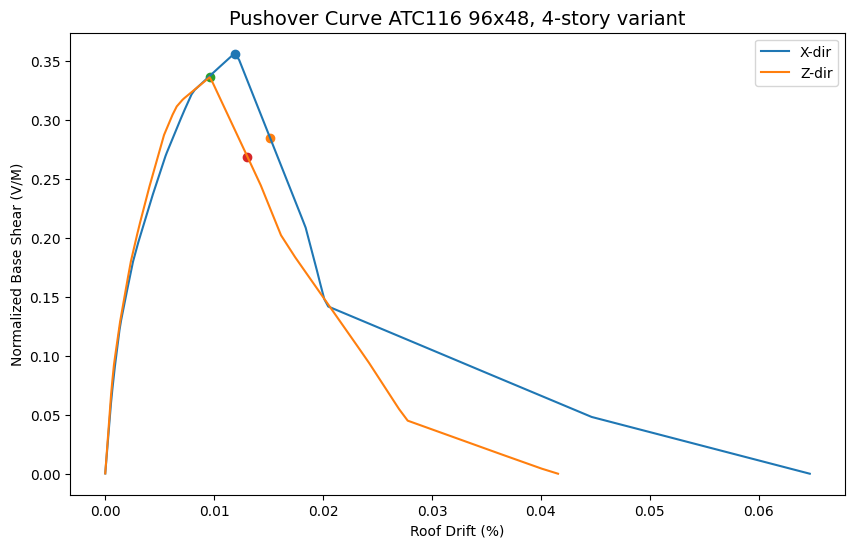

In [12]:
wt = np.loadtxt(os.path.join(cwd, *['BuildingInfo',BuildingList[0],'Loads','floorWeights.txt']))
SeismicWeight = np.sum(wt)

BaseDirectory = os.path.join(cwd, *['BuildingModels',BuildingList[0]])

PushoverX_rigid = epd.pushoverdata(BaseDirectory+ '/PushoverAnalysis/', 'X', 'roof', SeismicWeight, numFloors)
PushoverResultsX_rigid = epd.extractpushoverpoints(PushoverX_rigid)

PushoverY_rigid = epd.pushoverdata(BaseDirectory+ '/PushoverAnalysis/', 'Z', 'roof', SeismicWeight, numFloors)
PushoverResultsY_rigid = epd.extractpushoverpoints(PushoverY_rigid)

plt.figure(figsize = (10,6))
plt.plot(PushoverX_rigid[1],PushoverX_rigid[0],label = 'X-dir')
plt.plot(PushoverY_rigid[1],PushoverY_rigid[0],label = 'Z-dir')

plt.scatter(PushoverResultsX_rigid[1],PushoverResultsX_rigid[0])
plt.scatter(PushoverResultsX_rigid[2], 0.8*PushoverResultsX_rigid[0])

plt.scatter(PushoverResultsY_rigid[1],PushoverResultsY_rigid[0])
plt.scatter(PushoverResultsY_rigid[2], 0.8*PushoverResultsY_rigid[0])

plt.xlabel('Roof Drift (%)')
plt.ylabel('Normalized Base Shear (V/M)')
plt.title('Pushover Curve ATC116 96x48, 4-story variant', fontsize = 14)
plt.legend()

df = pd.DataFrame([PushoverResultsX_rigid, PushoverResultsY_rigid ], 
                  columns = ['Peak Strength', 'Drift at Peak', 'Drift at 80%Peak'],
                  index = ['X', 'Y'])
df.head()

## Post-processing Dyanmic Analysis results

Execute the following lines of only after all the dynamic analyses have been completed for all the hazard levels

In [ ]:
# NumGM = np.array([50, 47, 47, 48, 47])

# CollapseCriteria = 0.1
# DemolitionCriteria = 0.01

# HazardLevel = np.array([0.403, 0.975, 1.307, 1.676, 2.237])

# dynamicDirectory = os.path.join(cwd, *['BuildingModels',BuildingList[0],'DynamicAnalysis'])

# sdr = extractedps.ExtractSDR(dynamicDirectory, HazardLevel, NumGM, numFloors)
# rdr = extractedps.ExtractRDR(dynamicDirectory, HazardLevel, NumGM, NumStory)
# gmDirectory = r'C:\Users\Laxman\Desktop\Python Tool\BuildingModels\GM_sets\BoelterHall'
# PGA = extractedps.ExtractPGA(gmDirectory, HazardLevel, NumGM)
# pfa = extractedps.ExtractPFA(dynamicDirectory, HazardLevel, NumGM, NumStory, PGA, g = 386.4)


In [13]:
## for now I'm importing an example EDP data from another example for demonstration purposes
pfa = pd.read_csv(os.path.join(resultDirectory, 'PFA.csv'), header=None)
sdr = pd.read_csv(os.path.join(resultDirectory,'SDR.csv'), header=None)
rdr = pd.read_csv(os.path.join(resultDirectory,'RDR.csv'), header=None)

### preprocess input data for pelicun

In [14]:
index_name = []
median = []
log_std = []
#1-PFA-0-1
for stripe in pfa[0].unique():
    churn_df = pfa[pfa[0]==stripe]
    story_name = 0 
    for story in churn_df.columns:
        for uniq_dir in pfa[1].unique():
            if story >=3:
                story_name = story - 3
                index_name.append('%s-PFA-%s-%s'%(stripe, story_name, uniq_dir))
                median.append(pfa[(pfa[0]==stripe) & (pfa[1]==uniq_dir)][story].median())
                log_std.append(pfa[(pfa[0]==stripe) & (pfa[1]==uniq_dir)][story].std())
d = {
    'idx': index_name, 
    'median': median, 
    'log_std': log_std
}
df_pfa = pd.DataFrame(d)
df_pfa = df_pfa.set_index('idx')

## PID
index_name = []
median = []
log_std = []
#1-PID-0-1
for stripe in sdr[0].unique():
    churn_df = sdr[sdr[0]==stripe]
    story_name = 0 
    for story in churn_df.columns:
        for uniq_dir in sdr[1].unique():
            if story >=3:
                story_name = story - 2
                index_name.append('%s-PID-%s-%s'%(stripe, story_name, uniq_dir))
                median.append(sdr[(sdr[0]==stripe) & (sdr[1]==uniq_dir)][story].median())
                log_std.append(sdr[(sdr[0]==stripe) & (sdr[1]==uniq_dir)][story].std())
d = {
    'idx': index_name, 
    'median': median, 
    'log_std': log_std
}
df_sdr = pd.DataFrame(d)
df_sdr = df_sdr.set_index('idx')

## combine two dfs 
df_comb = pd.concat([df_pfa, df_sdr])
df_comb.head()

,median,log_std
idx,,
1-PFA-0-1,0.148458,0.095756
1-PFA-0-2,0.146941,0.083856
1-PFA-1-1,0.227519,0.125878
1-PFA-1-2,0.210666,0.113289
1-PFA-2-1,0.231842,0.126647
